<a href="https://colab.research.google.com/github/msolorzan/TensorFlow-projects/blob/main/Classification_Chapter_3_Mnist_Hands_on_Machine_Learning_with_Scikit_Learn%2C_Keras%2C_and_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
mnist = fetch_openml('mnist_784', version = 1)

In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
type(mnist)

sklearn.utils.Bunch

In [ ]:
X = mnist['data']
y = mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
random = np.random.randint(0, len(y))
some_digit = X.values[random]

In [ ]:
some_digit_image = some_digit.reshape(28, 28)

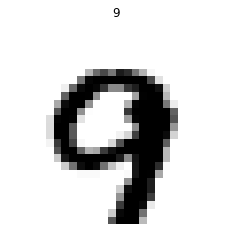

In [ ]:
plt.imshow(some_digit_image, cmap = 'binary')
plt.title(f'{y[random]}')
plt.axis(False)
plt.show()

In [ ]:
type(y)

pandas.core.series.Series

In [ ]:
y[0]

'5'

In [ ]:
# Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:
y = y.astype(np.uint8)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for
this classification task

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradi‐
ent Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier
has the advantage of being capable of handling very large datasets efficiently. This is
in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning), as we will see later. Let’s cre‐
ate an SGDClassifier and train it on the whole training set

In [ ]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

> The SGDClassifier relies on randomness during training (hence
the name “stochastic”). If you want reproducible results, you
should set the random_state parameter.


In [ ]:
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([False])

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this chapter on this topic. There are many performance
measures available, so grab another coffee and get ready to learn many new concepts
and acronyms!


## Measuring Accuracy Using Cross-Validation

The following code does roughly the same thing as Scikit-Learn’s
cross_val_score() function, and it prints the same result:

```
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
 clone_clf = clone(sgd_clf)
 X_train_folds = X_train[train_index]
 y_train_folds = y_train_5[train_index]
 X_test_fold = X_train[test_index]
 y_test_fold = y_train_5[test_index]
 clone_clf.fit(X_train_folds, y_train_folds)
 y_pred = clone_clf.predict(X_test_fold)
 n_correct = sum(y_pred == y_test_fold)
 print(n_correct / len(y_pred)) 
```

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score(estimator = sgd_clf, X = X_train, y = y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)


In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confu‐
sion matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the fifth row and third column of the confu‐
sion matrix.
To compute the confusion matrix, you first need to have a set of predictions so that
they can be compared to the actual targets. You could make predictions on the test
set, but let’s keep it untouched for now (remember that you want to use the test set
only at the very end of your project, once you have a classifier that you are ready to
launch). Instead, you can use the cross_val_predict() function

In [ ]:
from sklearn.model_selection import cross_val_predict

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [ ]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column repre‐
sents a predicted class. The first row of this matrix considers non-5 images (the nega‐
tive class): 53,057 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 1,522 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,325 were wrongly
classified as non-5s (false negatives), while the remaining 4,096 were correctly classi‐
fied as 5s (true positives). A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diago‐
nal (top left to bottom right):

In [ ]:
 y_train_perfect_predictions = y_train_5 # pretend we reached perfection

In [ ]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [ ]:
!mkdir imagenes_markdown

mkdir: cannot create directory ‘imagenes_markdown’: File exists


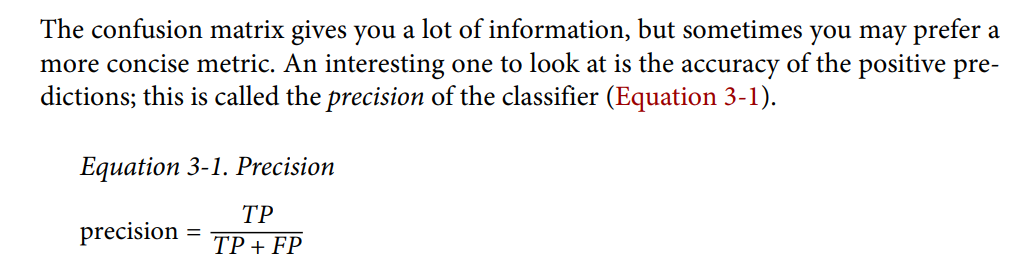![]('/content/imagenes_markdown/precision.png')

TP is the number of true positives, and FP is the number of false positives.
A trivial way to have perfect precision is to make one single positive prediction and
ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since
the classifier would ignore all but one positive instance. So precision is typically used
along with another metric named recall, also called sensitivity or the true positive rate
(TPR): this is the ratio of positive instances that are correctly detected by the classifier

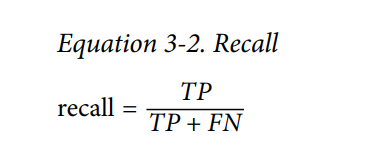

## Precision and Recall


In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The F1
 score is
the harmonic mean of precision and recall (Equation 3-3). Whereas the regular mean
treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the classifier will only get a high F1
 score if both recall and precision are
high.

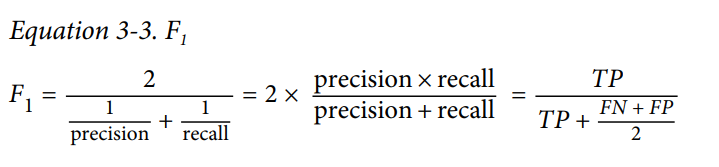

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Precision/Recall Trade-off
To understand this trade-off, let’s look at how the SGDClassifier makes its classifica‐
tion decisions. For each instance, it computes a score based on a decision function. If
that score is greater than a threshold, it assigns the instance to the positive class;
otherwise it assigns it to the negative class. Figure 3-3 shows a few digits positioned
from the lowest score on the left to the highest score on the right. Suppose the deci‐
sion threshold is positioned at the central arrow (between the two 5s): you will find 4
true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a
6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6
actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). If you raise the
threshold (move it to the arrow on the right), the false positive (the 6) becomes a true
negative, thereby increasing the precision (up to 100% in this case), but one true posi‐
tive becomes a false negative, decreasing recall down to 50%. Conversely, lowering
the threshold increases recall and reduces precision.

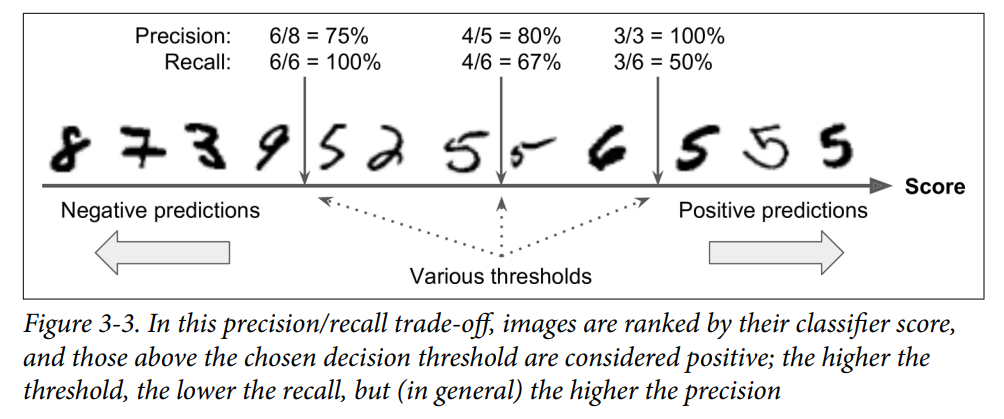

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([-20490.98732993])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,  method="decision_function")

In [ ]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.title('Precision and recall versus the decision threshold')
  plt.xlabel('Threshold')
  plt.grid(True)
  plt.legend()

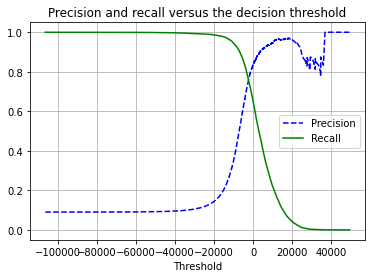

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

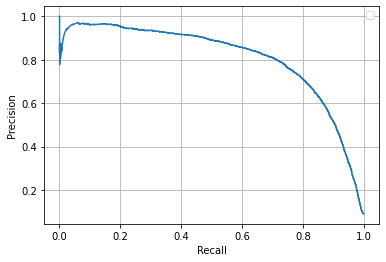

In [ ]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 

In [ ]:
threshold_90_precision

3370.019499143958

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [ ]:
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

## The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐
ting precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR). The FPR is the ratio of negative instan‐
ces that are incorrectly classified as positive. It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances that are correctly classified as negative.
The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) ver‐
sus 1 – specificity.

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
roc_curve(y_train_5, y_scores)

(array([0.        , 0.        , 0.        , ..., 0.99937705, 0.99937705,
        1.        ]),
 array([0.00000000e+00, 1.84467810e-04, 9.22339052e-04, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  49442.43765905,   49441.43765905,   36801.60697028, ...,
        -105763.22240074, -106527.45300471, -146348.56726174]))

In [ ]:
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

In [ ]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, label = label, linewidth = 2)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.grid(True)
  plt.legend()
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.show()

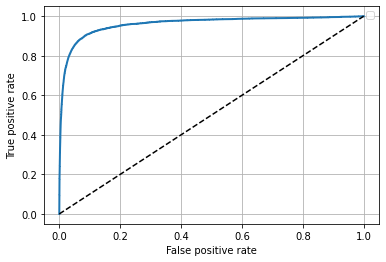

In [ ]:
plot_roc_curve(fpr = fpr, tpr = tpr)

Once again there is a trade-off: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).


_One way to compare classifiers is to measure the area under the curve (AUC). A per‐
fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:_

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

_Since the ROC curve is so similar to the precision/recall (PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the PR curve makes it clear that the classifier
has room for improvement (the curve could be closer to the topleft corner)._

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [ ]:
y_probas_forest.shape, type(y_probas_forest), y_probas_forest.max()

((60000, 2), numpy.ndarray, 1.0)

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

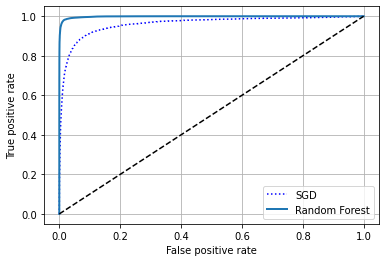

In [ ]:
plt.figure()
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes.
Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes
classifiers) are capable of handling multiple classes natively. Others (such as Logistic
Regression or Support Vector Machine classifiers) are strictly binary classifiers. How‐
ever, there are various strategies that you can use to perform multiclass classification
with multiple binary classifiers.


One way to create a system that can classify the digit images into 10 classes (from 0 to
9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-
detector, and so on). Then when you want to classify an image, you get the decision
score from each classifier for that image and you select the class whose classifier out‐
puts the highest score. This is called the one-versus-the-rest (OvR) strategy (also called
one-versus-all).


Another strategy is to train a binary classifier for every pair of digits: one to distin‐
guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
This is called the one-versus-one (OvO) strategy. If there are N classes, you need to
train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45
binary classifiers! When you want to classify an image, you have to run the image
through all 45 classifiers and see which class wins the most duels. The main advan‐
tage of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.


Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set. For these algorithms OvO is preferred because it is faster to
train many classifiers on small training sets than to train few classifiers on large train‐
ing sets. For most binary classification algorithms, however, OvR is preferred.

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([9], dtype=uint8)

That was easy! This code trains the SVC on the training set using the original target
classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes
(y_train_5). Then it makes a prediction (a correct one in this case). Under the hood,
Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their
decision scores for the image, and selected the class that won the most duels.


If you call the decision_function() method, you will see that it returns 10 scores
per instance (instead of just 1). That’s one score per class:

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([[ 5.85629679, -0.31302719,  3.84776293,  5.20607104,  7.27184297,
         1.7071773 ,  0.70228098,  8.30015622,  2.84437119,  9.31614251]])

In [ ]:
np.argmax(some_digit_scores)

9

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

**_When a classifier is trained, it stores the list of target classes in its
```classes_``` 
attribute, ordered by value. In this case, the index of each
class in the classes_ array conveniently matches the class itself
(e.g., the class at index 5 happens to be class 5), but in general you
won’t be so lucky._**

In [ ]:
svm_clf.classes_[0]

0

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you
can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an
instance and pass a classifier to its constructor (it does not even have to be a binary
classifier). For example, this code creates a multiclass classifier using the OvR strat‐
egy, based on an SVC

```
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

ovr_clf.predict([some_digit])

len(ovr_clf.estimators_)
```

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([9], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[-40633.45836189, -52070.95394096, -15505.50160916,
        -14424.13108301,  -7917.80908429, -19912.90241845,
        -41933.58341305,  -3821.0035025 ,  -1823.51979601,
         -1085.67226272]])

In [ ]:
np.max(sgd_clf.decision_function([some_digit])), np.argmax(sgd_clf.decision_function([some_digit]))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


(-1085.67226271661, 9)

You can see that the classifier is fairly confident about its prediction: almost all scores
are largely negative, while class 5 has a score of 2412.5. The model has a slight doubt
regarding class 3, which gets a score of 573.5. Now of course you want to evaluate this
classifier. As usual, you can use cross-validation. Use the cross_val_score() func‐
tion to evaluate the SGDClassifier’s accuracy

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

In [ ]:
X_train_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Error Analysis

If this were a real project, you would now follow the steps in your Machine Learning
project checklist (see Appendix B). You’d explore data preparation options, try out
multiple models (shortlisting the best ones and fine-tuning their hyperparameters
using GridSearchCV), and automate as much as possible. Here, we will assume that
you have found a promising model and you want to find ways to improve it. One way
to do this is to analyze the types of errors it makes.


* _First, look at the confusion matrix. You need to make predictions using the
cross_val_predict() function, then call the confusion_matrix() function, just like
you did earlier_

In [ ]:
y_trained_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)

In [ ]:
# With keepdims you can keep the dimension of the matrix (The dimension to be reduced keep in the value of dimension one)
